In [8]:
# import packages 

import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import itertools
import pickle
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier 


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import datasets
from sklearn.preprocessing import Imputer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc


from dateutil.parser import parse
from datetime import datetime
import dateutil.parser

import matplotlib.pyplot as plt
%matplotlib inline


import glob
import os
import zipfile

import warnings
warnings.filterwarnings('ignore')



sns.set_style("whitegrid")

# Foraging For Wild Mushrooms

In this study, we will be reading in a kaggle dataset that includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

We will be utilizing a number of supervised machine learning models to determine which mushrooms are poisonous and which are edible. To this end we will be using accuracy as our classification metric. To eat a mushroom that is poisonous can spell certain death in many cases, so we want to be ABSOLUTELY sure the mushroom we have identified is indeed edible.

With that said, let's dive in!

In [28]:
# read in shroom dataset
shroom_df = pd.read_csv('mushrooms.csv')

In [29]:
# basic EDA
shroom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

We see that all of the labels and our feature in the dataset are strings. We will need to convert them to integers in order to conduct this classification project. Let's first use the label encoder from sklearn to convert our target (edible vs. poisonous) into a 0-1 categorical.

In [30]:
from sklearn.preprocessing import LabelEncoder
# convert feature into 0-1 categorical
le = LabelEncoder()
shroom_df['class'] = le.fit_transform(shroom_df['class'])

Now, poisonous is represented by 1 and edible is represented by 0. Now, we can think of our classifier as “poisonous or not”. A poisonous mushroom gets a 1 (true), and an edible mushroom gets a 0 (false). Let's one-hot encode the rest of the features to continue with our analysis.

In [31]:
# get dummy variables for the remainder of the features (all currently objects). 
# lets also drop the first column so that we are not including our target in the encoded df!
encoded_df = pd.get_dummies(shroom_df, drop_first=True)

In [32]:
# ensure we do not have our target in the new df
encoded_df.columns

Index(['class', 'cap-shape_c', 'cap-shape_f', 'cap-shape_k', 'cap-shape_s',
       'cap-shape_x', 'cap-surface_g', 'cap-surface_s', 'cap-surface_y',
       'cap-color_c', 'cap-color_e', 'cap-color_g', 'cap-color_n',
       'cap-color_p', 'cap-color_r', 'cap-color_u', 'cap-color_w',
       'cap-color_y', 'bruises_t', 'odor_c', 'odor_f', 'odor_l', 'odor_m',
       'odor_n', 'odor_p', 'odor_s', 'odor_y', 'gill-attachment_f',
       'gill-spacing_w', 'gill-size_n', 'gill-color_e', 'gill-color_g',
       'gill-color_h', 'gill-color_k', 'gill-color_n', 'gill-color_o',
       'gill-color_p', 'gill-color_r', 'gill-color_u', 'gill-color_w',
       'gill-color_y', 'stalk-shape_t', 'stalk-root_b', 'stalk-root_c',
       'stalk-root_e', 'stalk-root_r', 'stalk-surface-above-ring_k',
       'stalk-surface-above-ring_s', 'stalk-surface-above-ring_y',
       'stalk-surface-below-ring_k', 'stalk-surface-below-ring_s',
       'stalk-surface-below-ring_y', 'stalk-color-above-ring_c',
       'stalk-color-

Before we continue, let's take a closer look at our target variable to see how balanced/imbalanced our classes are. This will determine if we need to do anything like oversampling (for class imbalance)

In [33]:
print(shroom_df.groupby('class').size())

class
0    4208
1    3916
dtype: int64


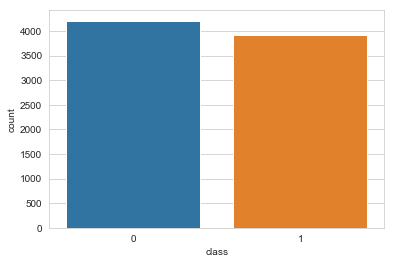

In [34]:
x = shroom_df['class']
class_plot = sns.countplot(x=x, data=shroom_df)

Looks like our two classes are almost perfectly balanced! Great, now let's begin modeling. Our first step is to split our dataset into our features and target (X and y respectively)

In [35]:
# split our dataset into features and target. Split for train/test
y = encoded_df['class'].values.reshape(-1,1)
X = encoded_df.drop(['class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Before we move on however, let's create a helper function for our training and testing across the different models.

In [36]:
def print_score(classifier,X_train,y_train,X_test,y_test,train=True):
    if train == True:
        print("Training results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_train,classifier.predict(X_train))))
        print('Classification Report:\n{}\n'.format(metrics.classification_report(y_train,classifier.predict(X_train))))
        print('Confusion Matrix:\n{}\n'.format(metrics.confusion_matrix(y_train,classifier.predict(X_train))))
        res = cross_val_score(classifier, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
        print('Average Accuracy:\t{0:.4f}\n'.format(res.mean()))
        print('Standard Deviation:\t{0:.4f}'.format(res.std()))
    elif train == False:
        print("Test results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_test,classifier.predict(X_test))))
        print('Classification Report:\n{}\n'.format(metrics.classification_report(y_test,classifier.predict(X_test))))
        print('Confusion Matrix:\n{}\n'.format(metrics.confusion_matrix(y_test,classifier.predict(X_test))))

### I. Logistic Regression

In [37]:
lg = LogisticRegression()
lg.fit(X_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [38]:
y_prob = lg.predict_proba(X_test)[:,1]   
y_pred = np.where(y_prob > 0.5, 1, 0) 
lg.score(X_test, y_pred)

1.0

In [54]:
coefs = lg.coef_

In [40]:
scores = cross_val_score(lg, X, y, cv=10, scoring='accuracy')
print(scores)

[0.68511685 1.         1.         1.         0.99384994 1.
 1.         1.         0.86313194 1.        ]


In [41]:
# train score
print_score(lg,X_train,y_train,X_test,y_test,train=True)

Training results:

Accuracy Score: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3385
           1       1.00      1.00      1.00      3114

   micro avg       1.00      1.00      1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499


Confusion Matrix:
[[3385    0]
 [   1 3113]]

Average Accuracy:	0.9995

Standard Deviation:	0.0007


In [42]:
# test score
print_score(lg,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       802

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Confusion Matrix:
[[823   0]
 [  0 802]]



In [45]:
import statsmodels.api as sm

m = LogisticRegression()
m.fit(X, y)

print(m.coef_)

[[ 5.72489214e-01 -2.70639241e-01 -1.48356124e-01 -6.29395551e-01
  -3.86261526e-01  1.08310141e+00  6.21227885e-01  4.94160814e-01
  -1.13691311e+00  1.21194295e-01 -1.42924602e-01 -4.74157005e-01
   6.53824026e-01 -5.15219816e-01 -5.15219816e-01  1.64959553e-01
  -5.97933690e-01 -4.24944460e-01  3.66950662e+00  3.12441899e+00
  -1.58854491e+00  2.65608397e-01 -4.19667692e+00  3.19640770e+00
   1.41558775e+00  1.41558775e+00  3.34789148e-01 -3.10256607e+00
   3.47359188e+00 -6.88571546e-01 -1.51865085e-01 -4.54564410e-02
  -5.30759779e-01 -8.58242534e-01 -2.01988397e-01 -6.84458341e-01
   7.10528220e-01 -3.02104901e-01 -5.33241623e-01  1.07871676e-01
  -1.11367335e+00  2.44415878e+00 -1.61790827e+00  8.19636535e-01
  -1.46453350e+00  1.93698144e+00 -7.46320091e-01  2.61469219e-01
   6.45359194e-01  1.09373319e-01  1.60928547e+00  2.65608397e-01
  -5.77055021e-01 -3.38589150e-01 -2.57635890e-01 -5.84664801e-01
   4.76047755e-01 -1.16637676e-01  8.14438700e-01  2.65608397e-01
  -4.74998

In [25]:
auc_roc = metrics.roc_auc_score(y_test,y_pred)
auc_roc

0.9993773349937733

In [17]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9999969655590957

Text(0.5, 0, 'False Positive Rate')

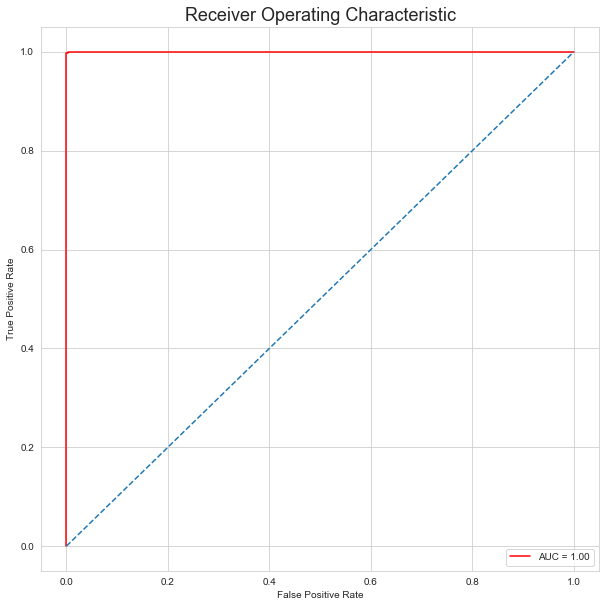

In [18]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic', fontsize = 18)
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Well...it appears that logistic regression gives us a virtually perfect model. If I were stuck in the woods with no food, I'd opt for this model to determine whether or not I could eat a particular mushroom. For fun, however, let's look at some of the other methods available to us and see how they compare.

### II. Naive Bayes

In [19]:
model_naive = GaussianNB()
model_naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [20]:
y_prob = model_naive.predict_proba(X_test)[:,1]   
y_pred = np.where(y_prob > 0.5, 1, 0) 
model_naive.score(X_test, y_pred)

1.0

In [21]:
scores = cross_val_score(model_naive, X, y, cv=10, scoring='accuracy')
print(scores)

[0.66789668 0.96186962 0.91266913 0.88314883 0.95325953 0.95694957
 0.87931034 0.8546798  0.93341554 0.87916153]


In [22]:
# train score
print_score(model_naive,X_train,y_train,X_test,y_test,train=True)


Training results:

Accuracy Score: 0.9520

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3363
           1       0.91      1.00      0.95      3136

   micro avg       0.95      0.95      0.95      6499
   macro avg       0.95      0.95      0.95      6499
weighted avg       0.96      0.95      0.95      6499


Confusion Matrix:
[[3051  312]
 [   0 3136]]

Average Accuracy:	0.9488

Standard Deviation:	0.0143


In [23]:
# test score
print_score(model_naive,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 0.9502

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       845
           1       0.91      1.00      0.95       780

   micro avg       0.95      0.95      0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625


Confusion Matrix:
[[767  78]
 [  3 777]]



In [24]:
auc_roc=metrics.roc_auc_score(y_test,y_pred)
auc_roc

0.9519230769230769

In [25]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9927916856319223

Text(0.5, 0, 'False Positive Rate')

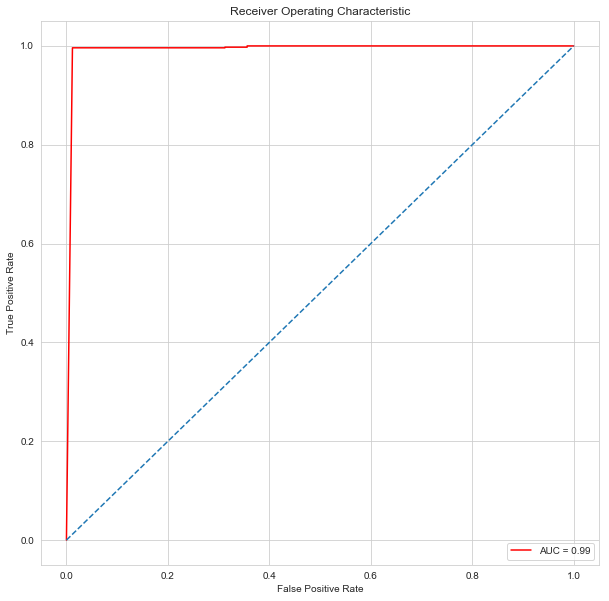

In [26]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### III. Support Vector Machine

In [27]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf',random_state=42)
classifier.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [28]:
# train score
print_score(classifier,X_train,y_train,X_test,y_test,train=True)

Training results:

Accuracy Score: 0.9978

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3363
           1       1.00      1.00      1.00      3136

   micro avg       1.00      1.00      1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499


Confusion Matrix:
[[3363    0]
 [  14 3122]]

Average Accuracy:	0.9972

Standard Deviation:	0.0015


In [29]:
# test score 
print_score(classifier,X_train,y_train,X_test,y_test,train=False)


Test results:

Accuracy Score: 0.9963

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       845
           1       1.00      0.99      1.00       780

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Confusion Matrix:
[[845   0]
 [  6 774]]



### IV. KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn = KNN()
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [31]:
y_prob = knn.predict_proba(X_test)[:,1]   
y_pred = np.where(y_prob > 0.5, 1, 0) 
knn.score(X_test, y_pred)

1.0

In [32]:
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.68757688 1.         1.         1.         1.         1.
 1.         1.         0.88902589 1.        ]


In [33]:
# train score
print_score(knn,X_train,y_train,X_test,y_test,train=True)


Training results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3363
           1       1.00      1.00      1.00      3136

   micro avg       1.00      1.00      1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499


Confusion Matrix:
[[3363    0]
 [   0 3136]]

Average Accuracy:	0.9995

Standard Deviation:	0.0007


In [34]:
# test score
print_score(knn,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       845
           1       1.00      1.00      1.00       780

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Confusion Matrix:
[[845   0]
 [  0 780]]



### V. Random Forest 

In [69]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [70]:
# train score
print_score(forest,X_train,y_train,X_test,y_test,train=True)

Training results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      1.00      1.00       267

   micro avg       1.00      1.00      1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426


Confusion Matrix:
[[159   0]
 [  0 267]]

Average Accuracy:	0.9624

Standard Deviation:	0.0300


In [71]:
# test score
print_score(forest,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 0.9580

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        53
           1       0.96      0.98      0.97        90

   micro avg       0.96      0.96      0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143


Confusion Matrix:
[[49  4]
 [ 2 88]]



## Feature Importance

It's great that we have so many intensely accurate models. However, we should spend a bit of time looking at our features to determine which have a strong correlation to being either poisonous or edible. In the real world, we'll need to know which features are mostly strongly indicative of the mushroom's edibility and because we have such strong models, I'd bet that one or two features are vitally important for this classification problem.

Let's take a look again at our random forest model and see if we can track down the most important features here.

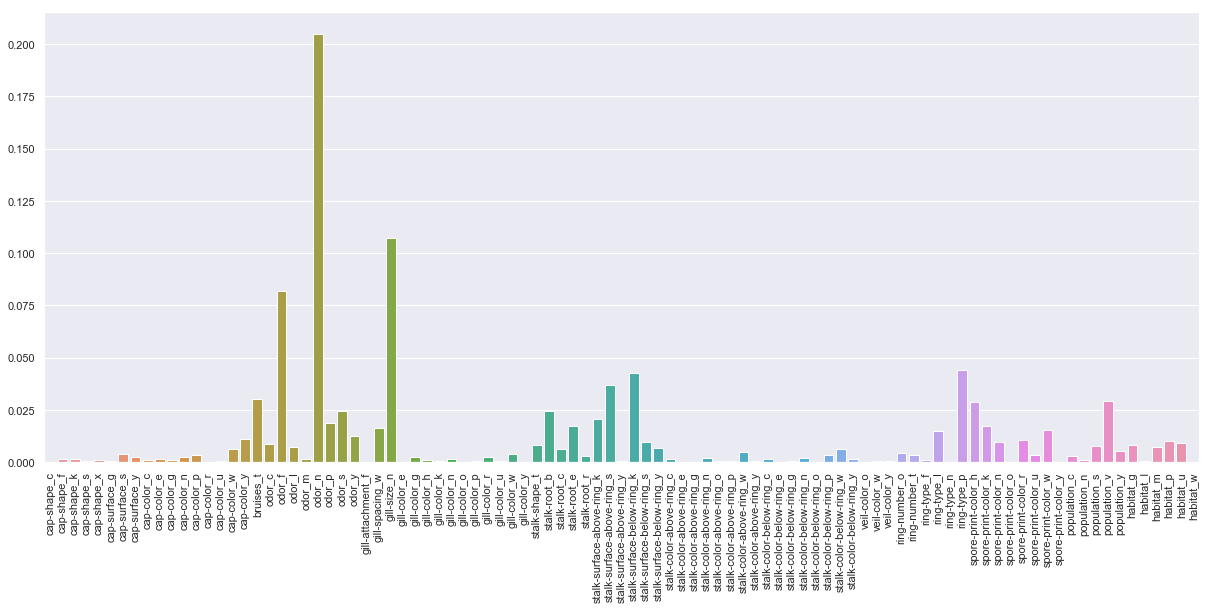

In [84]:
from matplotlib import pyplot


importances = rfc.feature_importances_
plot = sns.barplot(x=X.columns, y=importances)

for item in plot.get_xticklabels():
    item.set_rotation(90)
    
sns.set(rc={'figure.figsize':(30.7,8.27)})



Whoa! Odor has the highest feature importance in the Random Forest. We can explore the effect of odor on the predicted class a bit further with this next plot.

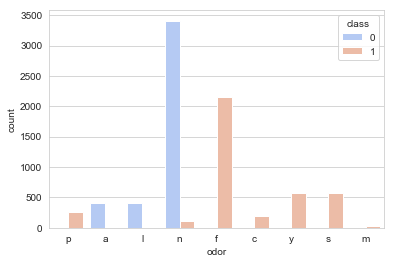

In [74]:
sns.countplot(x = 'odor', data = shroom_df, hue='class', palette='coolwarm')
plt.show()

From the above, it is clear how important odor is in predicting the right classes. Most odor categories are only linked to one outcome class. And for odor 'n' almost all mushrooms belong to class 0 or edible. After looking at this, it is very clear why all our models did so well! 

With this said, 'n' odor refers to 'pungent' in our dataset and I'm not sure I trust myself to know exactly what that is...

Another

For fun, let's also look at gill_size as that is the second most important feature according to our graph above.

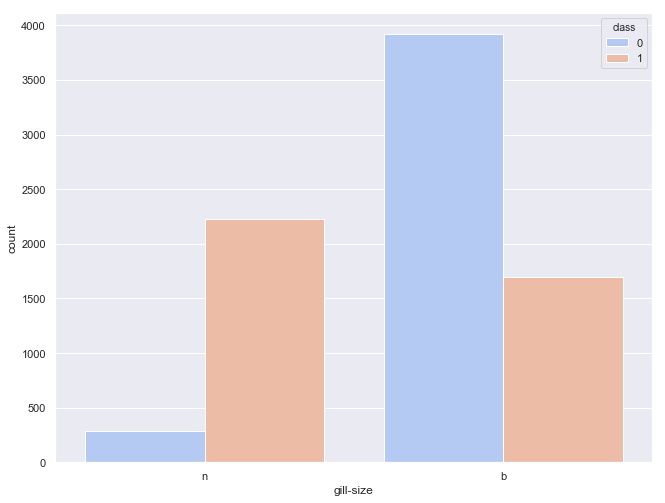

In [88]:
sns.countplot(x = 'gill-size', data = shroom_df, hue='class', palette='coolwarm')
plt.show()
sns.set(rc={'figure.figsize':(7,8.27)})

Wow! It also looks like gill size has quite a bit to do with our classification model. According to the above chart, a gill size of b (which means broad) is nearly perfectly correlated to an edible shroom.

Alright, so just find yourself a pungent smelling, broad gilled shroom and you are good to go!

One tip I found for odor is: 'Keep in mind that while many mushrooms' odors are very strong, in some cases it's more subtle. Crushing a little bit of the mushroom's cap helps bring out its odor.'

### Concluding Thoughts

Well, it appears that we just have data that is strongly indicative of whether or not a mushroom is poisonous or not. With the exception of Naive Bayes, we have a 99-100% accuracy across all our models. 

However, let's be practical here. While it is exciting to know that features of a mushroom (cap size, habitat etc.) can accuractely predict whether or not a mushroom is poisonous, it isn't terribly helpful in the real-world. For example, one wouldn't intuitively know all of these features if in the wild and searching for food. 

What most people do have on them, however, is a phone. Why don't we try then to classify mushrooms as being edible or not simply by their images.

For this, we will need to utilize tensorflow, keras and a new technique called deep learning.

Let's do it!

## Up Next: Mushroom Image Classification (Mushroom Image Classifier in Repo)